# Reconocimiento de dígitos con KNN

Veamos como interactuar con las clases implementadas en el módulo de C++ haciendo una experimentación muy simplificada, y a modo de ejemplo, del método KNN para reconocer digitos

## Compilando el módulo desde C++

Definir los path al ejecutable de python 3.6 y sus librerías,
de acuerdo al virtual env que estén corriendo.

In [4]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/tincho/Development/tp2 gitlab/tp2/bin/python (found version "3.8.10") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/tincho/Development/tp2 gitlab/mn-tp2
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tincho/Development/tp2 

In [5]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum

/home/tincho/Development/tp2 gitlab/mn-tp2/notebooks
Python 3.8.10


## Explorando los datos

In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd

df_train = pd.read_csv("../data/train.csv")

Es un csv, con columnas por cada pixel

In [7]:
df_train[:10]

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Reducir el dataset

Ya que el dataset es grande, me quedo con una porción de éste

**<font color=red>ESTO ES SOLO PARA HACER PRUEBAS. CUANDO REPORTEN LOS RESULTADOS, USAR DATASET COMPLETO</font>**

In [8]:
df_train = df_train[:5000]

En el primer caracter está el dígito a reconocer. Llamamos a esto `y_train`

In [9]:
# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X.shape, y.shape

((5000, 784), (5000, 1))

Convierto el resto a matrices de 28 x 28

A ver cómo se ven...

Supuestamente es un 7


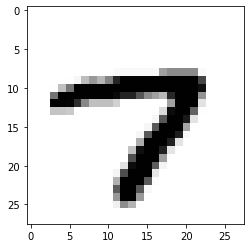

In [10]:
import matplotlib.pyplot as plt

num = 1917

print(f"Supuestamente es un {int(y[num])}")

img = X[num].reshape(28, 28)
plt.imshow(img, cmap="Greys")


### Balance de clases

¿Tenemos la misma cantidad de cada número?

In [11]:
df_train["label"].value_counts(normalize=True)

1    0.1116
2    0.1090
6    0.1032
7    0.1012
0    0.0988
3    0.0960
9    0.0956
4    0.0954
8    0.0954
5    0.0938
Name: label, dtype: float64

No: tenemos más 1 que 5, pero tampoco está tan desbalanceado

### Conjunto de development

In [12]:
limit = int(0.8 * X.shape[0]) 

X_train, y_train = X[:limit], y[:limit]
X_val, y_val = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_val)} de validación")


Ahora tengo 4000 instancias de entrenamiento y 1000 de validación


In [13]:
from sklearn.neighbors import KNeighborsClassifier

# Acá pueden cambiar el clasificador nuestro por el de sklearn!

clf = metnum.KNNClassifier(100)
#clf = KNeighborsClassifier(100)

clf.fit(X_train, y_train)


In [14]:
%%time
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Accuracy: {}".format(acc))


Accuracy: 0.832
CPU times: user 3.55 s, sys: 0 ns, total: 3.55 s
Wall time: 3.54 s


# Empiezo con la investigacion 

## Implementacion de KFold

#### Vamos a experimentar la variacion de datos de k y alfa utilizando como metodo el KFold Cross Validation. Lo que hace es dividir nuestra muestra de datos en K subconjuntos, y bajo una metrica que elijamos, aplicarle el kNN con o sin PCA segun corresponda, para luego chequear sus resultados

#### Agarro una muestra pequena del train ya provisto por la catedra

In [15]:
df_train_small = df_train.sample(500) # Empiezo usando 500 datos primero
df_train_small.shape

X_train = df_train_small[df_train_small.columns[1:]].values
y_train = df_train_small["label"].values

print(X_train.shape)
print(y_train.shape)

(500, 784)
(500,)


#### Comienzo con una funcion de KFold que me estime la performance de los metodos codeados en C++

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
from time import time
import numpy as np

def kNN_KFold(k, X, y):
    # No confundir K de K-fold con k de kNN!!
    kfold = KFold(10)
    accuracyArr = []
    F1Arr = []
    
    for train_index, test_index in kfold.split(X):
        # Separamos el conjunto de entrenamiento y el conjunto de test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        ### ESTO QUEDA IGUAL ###
        # Inicializamos un nuevo clasificador cada iteracion.
        kNN = metnum.KNNClassifier(k)
        
        # Entreno a la maquina con los K-1 subsets asignados.
        kNN.fit(X_train, y_train)

        # Ahora hago la prediccion con los X_val que se usan para validar la iteracion de entrenamiento actual.
        y_pred = kNN.predict(X_test)
        
        # Comparo las predicciones con los resultados esperados.
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="macro")
        ### ESTO QUEDA IGUAL ###
        
        accuracyArr.append(acc)
        F1Arr.append(f1)
        
    accuracyArr = np.asarray(accuracyArr)
    F1Arr = np.asarray(F1Arr)
    
    mediaAccuracy = np.mean(accuracyArr)
    mediaF1 = np.mean(F1Arr)
    
    return mediaAccuracy, mediaF1

## Variacion de 'k'

### kNN sin PCA

#### 'k' = 50

In [17]:
#%%time #Tarda como 40 segundos
def estudio_k(k, X, y):
    accuracyList = []
    F1List = []
    for i in range(1, k):
        mediaAccuracy, mediaF1 = kNN_KFold(int(i), X, y)
        accuracyList.append(mediaAccuracy)
        F1List.append(mediaF1)

    accuracyList = np.asarray(accuracyList)
    F1List = np.asarray(F1List)
    
    return accuracyList, F1List

In [18]:
accuracy50 , FOne50 = estudio_k(50, X_train, y_train)

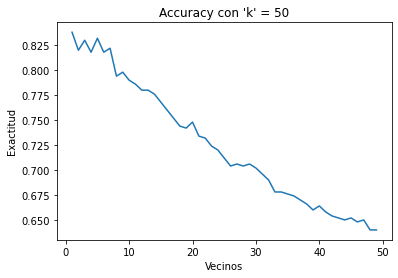

CPU times: user 179 ms, sys: 56.2 ms, total: 235 ms
Wall time: 89.6 ms


In [20]:
%%time

plt.figure("Accs with k")
plt.plot(range(1, 50), accuracy50)
plt.xlabel("Vecinos")
plt.ylabel("Exactitud")
plt.title("Accuracy con 'k' = 50")
plt.show()

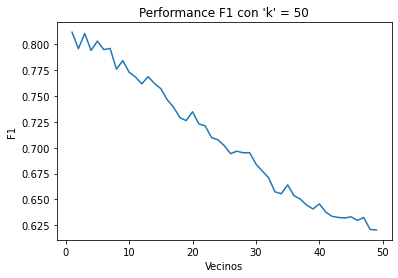

CPU times: user 158 ms, sys: 72 ms, total: 230 ms
Wall time: 90 ms


In [21]:
%%time

plt.figure("F1 with k")
plt.plot(range(1, 50), FOne50)
plt.xlabel("Vecinos")
plt.ylabel("F1")
plt.title("Performance F1 con 'k' = 50")
plt.show()

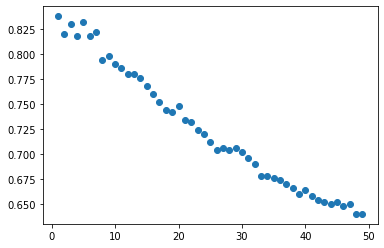

In [22]:
from matplotlib import pyplot
# pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
# pyplot.plot(range(1, 50), accuracy50, color='r')
pyplot.errorbar(range(1, 50), accuracy50, fmt='o')
# show the plot
pyplot.show()

#### 'k' = 100

In [23]:
accuracy100 , FOne100= estudio_k(100, X_train, y_train)

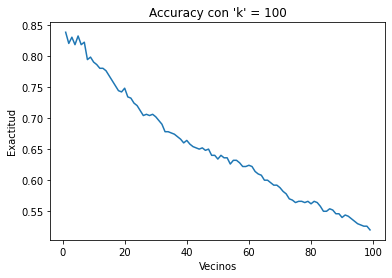

CPU times: user 186 ms, sys: 48.2 ms, total: 235 ms
Wall time: 88.9 ms


In [25]:
%%time

plt.figure("Accs with k")
plt.plot(range(1, 100), accuracy100)
plt.xlabel("Vecinos")
plt.ylabel("Exactitud")
plt.title("Accuracy con 'k' = 100")
plt.show()

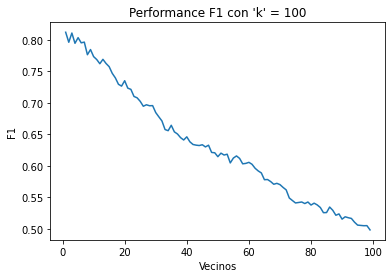

CPU times: user 175 ms, sys: 56 ms, total: 231 ms
Wall time: 90 ms


In [26]:
%%time
plt.figure("F1 with k")
plt.plot(range(1, 100), FOne100)
plt.xlabel("Vecinos")
plt.ylabel("F1")
plt.title("Performance F1 con 'k' = 100")
plt.show()

## Variacion de tamano de la muestra

### Sin PCA

In [27]:
def muestra(cant):
    df_train_custom = df_train.sample(cant)
    X_custom = df_train_custom[df_train_custom.columns[1:]].values
    y_custom = df_train_custom["label"].values
    
    return df_train_custom, X_custom, y_custom

#### K = 25 (todos con k = 50)

In [ ]:
df_train_25, X_train25, y_train25 = muestra(25)
accuracyI , FOneI= estudio_k(50, X_train25, y_train25)

#### K = 100

In [ ]:
df_train_100, X_train100, y_train100 = muestra(100)
accuracyII , FOneII= estudio_k(50, X_train100, y_train100)

#### K = 1000

In [68]:
df_train_1000, X_train1000, y_train1000 = muestra(1000)
accuracyIII , FOneIII= estudio_k(50, X_train1000, y_train1000)

#### K = 1500

In [69]:
df_train_1500, X_train1500, y_train1500 = muestra(1500)
accuracyIV , FOneIV= estudio_k(50, X_train1500, y_train1500)

#### Grafico todos los tipos de muestra para ver en que se diferencia su performance 

In [ ]:
#plt.plot([1,5,10,50,100,200],[0.508, 0.575, 0.590, 0.645, 0.646, 0.643], label='k=100')  #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.507, 0.569, 0.590, 0.642, 0.648, 0.634], label='k=500')  #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.510, 0.563, 0.578, 0.646, 0.661, 0.662], label='k=1500') #La primera lista son los alfas y la segunda los accuracy
#plt.plot([1,5,10,50,100,200],[0.509, 0.557, 0.569, 0.626, 0.649, 0.658], label='k=2000') #La primera lista son los alfas y la segunda los accuracy
#plt.axis([1, 200, 0.5,0.7])
plt.plot(range(1, 50), accuracyI, label='muestra=25')
plt.plot(range(1, 50), accuracyII, label='muestra=100')
plt.plot(range(1, 50), accuracyIII, label='muestra=1000')
plt.plot(range(1, 50), accuracyIV, label='muestra=1500')
plt.xlabel("Vecinos")
plt.ylabel("Accuracy")
plt.title("Performance metrica accuracy dependiendo tamano de la muestra")
plt.show()

### Con PCA

## Variacion de '\\( \alpha \\)'

## Variacion de 'K'